In [2]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm
from efficientnet_pytorch import EfficientNet


C:\tools\Anaconda\envs\FPY_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
efficientnet_b0 = EfficientNet.from_pretrained('efficientnet-b0')

efficientnet_b0._fc = torch.nn.Linear(efficientnet_b0._fc.in_features, 2)

efficientnet_b0.load_state_dict(torch.load('saved_models/Combined-DEPTH.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
efficientnet_b0 = efficientnet_b0.to(device)
efficientnet_b0.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Loaded pretrained weights for efficientnet-b0


C:\Users\ajeet\AppData\Local\Temp\ipykernel_32344\12255259.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_b0.load_state_dict(torch.load('saved_models/Combi

Using device: cuda


In [6]:
def predict_fn(images):
    batch = torch.stack([transform(Image.fromarray(img)) for img in images])
    batch = batch.to(device)

    with torch.no_grad():
        logits = efficientnet_b0(batch)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    return probs

100%|███████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 242.35it/s]


LIME Output Shape: (1, 2)
Example Prediction: [0.20578852 0.7942115 ]
Predicted class: Unstable with probability 0.7942


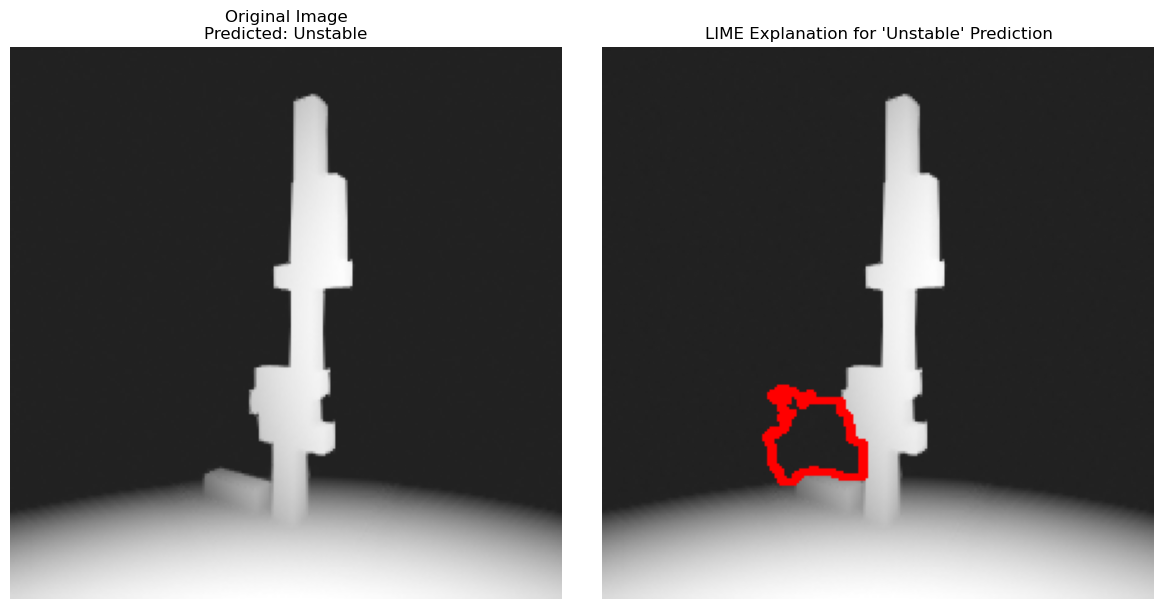

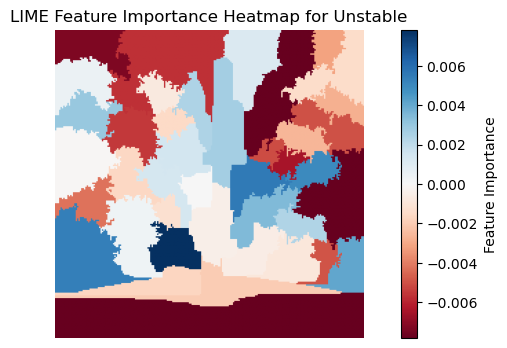

In [89]:

img_path = "Test_Dataset/ColourTest3/Depth_Blender/Before/depth_233_persp_right.png0001.png"
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)

explainer = lime_image.LimeImageExplainer()

segmenter = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=100, ratio=0.1)

explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    top_labels=2, 
    hide_color=0,
    num_samples=800 
    , segmentation_fn=segmenter
)
lime_output = predict_fn([image_np])
print("LIME Output Shape:", lime_output.shape)
print("Example Prediction:", lime_output[0])

preds = predict_fn(np.array([image_np]))
pred_class = np.argmax(preds[0])
class_names = ['Stable', 'Unstable']
print(f"Predicted class: {class_names[pred_class]} with probability {preds[0][pred_class]:.4f}")

temp, mask = explanation.get_image_and_mask(
    label=pred_class,
    positive_only=True, 
    hide_rest=False,
    num_features=1,
    min_weight=0.0
)


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title(f"Original Image\nPredicted: {class_names[pred_class]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), outline_color=(1, 0, 0)))
plt.title(f"LIME Explanation for '{class_names[pred_class]}' Prediction")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
ind = explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar(label='Feature Importance')
plt.title(f'LIME Feature Importance Heatmap for {class_names[pred_class]}')
plt.axis('off')
plt.show()